Data Incubator Project proposaL: 
 Data Source: Tennis Abstract WTA player data - player physical characteristics, age-based play statistics
 Goal: To identify player types and predict future highly ranked players based on characteristics
 Meta-Goal: To break vicious cycle of women's sports being less popular -> covered less -> less compelling analysis
 This Notebook: Data Wrangling and Exploratory Data Analysis

In [18]:
# Load useful packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests
from selenium import webdriver
import re
import datetime
import sklearn

In [2]:
# Scraping tennis abstract site to build out player database starting with all current WTA players with at least 1 rankings pt
URL = 'http://tennisabstract.com/reports/wtaRankings.html'
response = requests.get(URL)
if response.status_code != 200:
    print(f'Error accessing URL. Error Code: {response.status_code}')
else:
    soup = BeautifulSoup(response.text, 'lxml')
    player_table = soup.find(id='reportable')
    if player_table is None:
        print('Error finding Player Table')
    else:
        players = player_table.find_all('a')
        num_players = len(players)
        playerDF = pd.DataFrame(index=range(num_players), columns=['name', 'link', 'dob', 'hand', 'backhand'])
        for i, player in enumerate(players):
            link = player.get('href')
            name = link.split('p=')[1]
            playerDF.loc[i, 'link'] = link
            playerDF.loc[i, 'name'] = name

        print(playerDF.head())

               name                                               link  dob  \
0     AshleighBarty  http://www.tennisabstract.com/cgi-bin/wplayer....  NaN   
1  KarolinaPliskova  http://www.tennisabstract.com/cgi-bin/wplayer....  NaN   
2        NaomiOsaka  http://www.tennisabstract.com/cgi-bin/wplayer....  NaN   
3   BiancaAndreescu  http://www.tennisabstract.com/cgi-bin/wplayer....  NaN   
4       SimonaHalep  http://www.tennisabstract.com/cgi-bin/wplayer....  NaN   

  hand backhand  
0  NaN      NaN  
1  NaN      NaN  
2  NaN      NaN  
3  NaN      NaN  
4  NaN      NaN  


In [3]:
#from selenium.webdriver.chrome.options import Options  

#chrome_options = Options()
#chrome_options.add_argument("--headless")

#link = playerDF.iloc[0,1]
#browser = webdriver.Chrome(executable_path = 'C:\\Program Files\\ChromeDriver\\chromedriver_win32\\chromedriver.exe',
#                          options = chrome_options)
#browser.get(link)
#bio_data = browser.find_element_by_id('biog')

In [374]:
# Scrape tennis abstract site for each player's details: dob, handedness, 1v2 handed backhand, was once number 1


for i in range(num_players): 
    link = playerDF.iloc[i,1]
    response = requests.get(link)
    if response.status_code != 200: 
        print(f'Error accessing URL. Error Code: {response.status_code}')
    else: 
        soup = BeautifulSoup(response.text)
    #relevant data is in javascript variables
    vardata = soup.find_all('script')[3].text
    playerDF.loc[i, 'statslink'] = soup.find_all('script')[2].get('src')
    dobtext = re.search('\nvar dob = (?P<year>\d{4})(?P<month>\d{2})(?P<day>\d{2})', vardata)
    if dobtext: 
        if int(dobtext.group('year')) > 1950: 
            playerDF.loc[i, 'dob'] = datetime.datetime(int(dobtext.group('year')),
                            int(dobtext.group('month')),
                            int(dobtext.group('day')))
        
    text = re.search('\nvar hand = \'(?P<hand>[A-Z])', vardata)
    if text: 
        if text.group('hand') != 'U':
            playerDF.loc[i, 'hand'] = text.group('hand')


    text = re.search('\nvar backhand = \'(?P<backhand>\d)', vardata)
    if text: 
        playerDF.loc[i, 'backhand'] = text.group('backhand')
        
    if re.search('\nvar peakrank = 1;', vardata): 
        playerDF.loc[i, 'numberone'] = True
    else: 
        playerDF.loc[i, 'numberone'] = False

playerDF.head()


,name,link,dob,hand,backhand,statslink,matches_2018,dominance_2018,winpercent_2018,setpercent_2018,gamepercent_2018,serveptswonpercent_2018,returnptswonpercent_2018,matches_2019,dominance_2019,wtarank_2019,pts_2019,wtarank_2018,pts_2018,numberone
0,AshleighBarty,http://www.tennisabstract.com/cgi-bin/wplayer....,1996-04-24 00:00:00,R,2,http://www.minorleaguesplits.com/tennisabstrac...,65.0,1.19,0.708,0.664,0.562,63.6%,43.3%,67.0,1.22,1,6476,15,2985,True
1,KarolinaPliskova,http://www.tennisabstract.com/cgi-bin/wplayer....,1992-03-21 00:00:00,R,2,http://www.minorleaguesplits.com/tennisabstrac...,77.0,1.09,0.701,0.635,0.543,60.2%,43.4%,63.0,1.17,2,5315,8,4465,True
2,NaomiOsaka,http://www.tennisabstract.com/cgi-bin/wplayer....,1997-10-16 00:00:00,R,2,http://www.minorleaguesplits.com/tennisabstrac...,65.0,1.13,0.662,0.654,0.568,61.0%,43.8%,49.0,1.16,3,5246,5,5115,True
3,BiancaAndreescu,http://www.tennisabstract.com/cgi-bin/wplayer....,2000-06-16 00:00:00,R,2,http://www.minorleaguesplits.com/tennisabstrac...,7.0,1.02,0.571,0.647,0.530,56.8%,44.1%,43.0,1.18,4,5041,152,382,False
4,SimonaHalep,http://www.tennisabstract.com/cgi-bin/wplayer....,1991-09-27 00:00:00,R,2,http://www.minorleaguesplits.com/tennisabstrac...,59.0,1.22,0.797,0.722,0.593,59.1%,49.7%,59.0,1.16,5,4962,1,6921,True


In [364]:
# Get even more detailed statistics for top 200 players to start
statcolumns = ['year', 'matches', 'matches-won', 'matches-lost', 'winpercent',
             'setwinloss', 'setpercent', 'gamewinloss', 'gamepercent',
             'tiebreakwinloss','tiebreakpercent', 'matchstats', 'hldpercent',
             'brkpercent', 'acepercent', 'dfpercent', 'firstinpercent', 
             'firstwonpercent', 'secondwonpercent', 'serveptswonpercent', 
             'returnptswonpercent', 'ptswonpercent', 'dominanceratio']

rankcolumns = ['year','wtarank', 'pts', 'elorank', 'elopts', 'helorank',
                                            'helopts', 'celorank', 'celopts', 'gelorank', 'gelopts', 
                                            'dblswtarank', 'dblspts', 'dlorank', 'dlo']


PAST_TWO_YEAR_STATISTICS = [2019, 2018]
PAST_TWO_YEAR_RANKINGS = ['Current (2019-10-21)', '2018']


def floatpercentstr(string): 
    if type(string) is str: 
        if re.search('[0-9.]*%', string): 
            return float(re.search('[0-9.]*%', string).group(0)[:-1])/100
        else: 
            return np.nan
    else: 
        return string

# counter for number of players with past two year data
#count = 0    
    
for i in range(num_players): 
    link = playerDF.loc[i,'statslink']
    response = requests.get(link)
    if response.status_code != 200: 
        print(f'Error accessing URL. Error Code: {response.status_code}')
    else: 
        soup = BeautifulSoup(response.text)
        
            # Get year-over-year tour win statistics
        try: 
            tourseasons = soup.find(id="tour-years").find('tbody').find_all('tr')
            stats = []

            for season in tourseasons[:-1]: 
                stats.append([td.text for td in season.find_all('td')[:-1]]) 

            statistics = pd.DataFrame(stats, columns = statcolumns)

            # convert counting statistics into integers and percentages and ratios into floats
            statistics[['year', 'matches']]=statistics[['year', 'matches']].applymap(int)
            statistics['dominanceratio'] = pd.to_numeric(statistics['dominanceratio'], errors = 'coerce')
            statistics[['winpercent', 'setpercent', 'gamepercent', 'ptswonpercent']] = statistics[['winpercent', 'setpercent', 'gamepercent', 'ptswonpercent']].applymap(lambda x: floatpercentstr(x))
        except: 
            continue 
        # Get year end rankings
        try: 
            yearend = soup.find(id="year-end-rankings").find('tbody').find_all('tr')
            rankings = []
            for year in yearend: 
                rankings.append([td.text for td in year.find_all('td')])

            rankings = pd.DataFrame(rankings, columns = rankcolumns)
    
            if all([year in statistics['year'].values for year in PAST_TWO_YEAR_STATISTICS]): 
                if all([year in rankings['year'].values for year in PAST_TWO_YEAR_RANKINGS]): 
                    playerDF.loc[i, 'matches_2018'] = statistics.loc[statistics['year'] == 2018,'matches'].values[0]
                    playerDF.loc[i, 'dominance_2018'] = statistics.loc[statistics['year'] == 2018,'dominanceratio'].values[0]
                    playerDF.loc[i, 'winpercent_2018'] = statistics.loc[statistics['year'] == 2018,'winpercent'].values[0]
                    playerDF.loc[i, 'setpercent_2018'] = statistics.loc[statistics['year'] == 2018,'setpercent'].values[0]
                    playerDF.loc[i, 'gamepercent_2018'] = statistics.loc[statistics['year'] == 2018,'gamepercent'].values[0]
                    playerDF.loc[i, 'serveptswonpercent_2018'] = statistics.loc[statistics['year'] == 2018,'serveptswonpercent'].values[0]
                    playerDF.loc[i, 'returnptswonpercent_2018'] = statistics.loc[statistics['year'] == 2018,'returnptswonpercent'].values[0]
                    playerDF.loc[i, 'matches_2019'] = statistics.loc[statistics['year'] == 2019,'matches'].values[0]
                    playerDF.loc[i, 'dominance_2019'] = statistics.loc[statistics['year'] == 2019,'dominanceratio'].values[0]
                    playerDF.loc[i, 'wtarank_2019'] = rankings.loc[rankings['year'] == PAST_TWO_YEAR_RANKINGS[0], 'wtarank'].values[0]
                    playerDF.loc[i, 'pts_2019'] = rankings.loc[rankings['year'] == PAST_TWO_YEAR_RANKINGS[0], 'pts'].values[0]
                    playerDF.loc[i, 'wtarank_2018'] = rankings.loc[rankings['year'] == PAST_TWO_YEAR_RANKINGS[1], 'wtarank'].values[0]
                    playerDF.loc[i, 'pts_2018'] = rankings.loc[rankings['year'] == PAST_TWO_YEAR_RANKINGS[1], 'pts'].values[0]
                    count+=1
        except: 
            continue

print(count)

(200, 0)

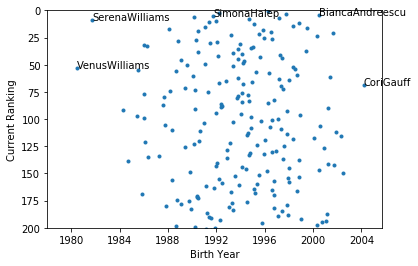

In [365]:
# Look at player birth year vs rankings
plt.figure()
plt.plot(playerDF['dob'].dropna().values,playerDF['dob'].dropna().index+1, '.')
plt.xlabel('Birth Year')
plt.ylabel('Current Ranking')
ax = plt.gca()

def getplayerdata(name, cols = []): 
    return playerDF[playerDF['name'] == name][cols]

famous_names = ['SerenaWilliams', 'VenusWilliams', 'BiancaAndreescu', 'SimonaHalep', 'CoriGauff']
for name in famous_names: 
    a = getplayerdata(name, ['dob']).values
    b = playerDF[playerDF['name'] == name].index[0]+1
    ax.annotate(name, (a[0][0], b))
ax.invert_yaxis()
ax.set_ylim(200,0)

237 players in analysis
Linear Regression Score: 0.27852948809025313
Lasso Regression Score: 0.2950222798947413


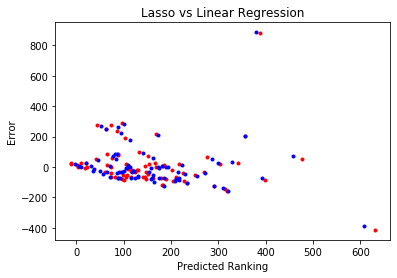

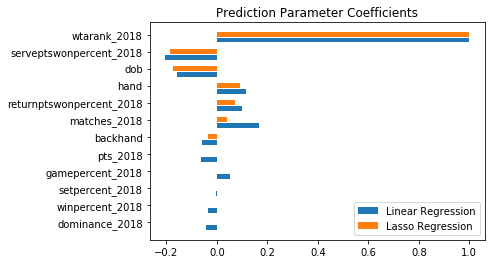

In [416]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

subset = playerDF.drop(['numberone'], axis = 1).dropna(how = 'any')
subset.replace('', np.nan, inplace=True)
subset = subset.dropna(how = 'any')
print(f'{len(subset)} players in analysis')
y = subset['wtarank_2019'].apply(int).values
subset['dob'] = subset['dob'].apply(mdates.date2num)
def handLR(handstring): 
    """use 0 for Right handed, 1 for lefthanded, none for anything else"""
    if handstring == 'R': 
        return 0
    elif handstring == 'L': 
        return 1
    else: 
        return None
subset['hand'] = subset['hand'].apply(handLR) 
subset[['backhand', 'wtarank_2018', 'pts_2018']] = subset[['backhand','wtarank_2018', 'pts_2018']].applymap(int)
subset[['serveptswonpercent_2018', 'returnptswonpercent_2018']]  = subset[['serveptswonpercent_2018', 'returnptswonpercent_2018']].applymap(floatpercentstr)
params = subset.drop(['name', 'link', 'statslink', 'matches_2019', 'dominance_2019', 'wtarank_2019', 'pts_2019'], axis = 1).columns
X = subset.drop(['name', 'link', 'statslink', 'matches_2019', 'dominance_2019', 'wtarank_2019', 'pts_2019'], axis = 1).values

scaler = StandardScaler()
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 0)

linreg = LinearRegression(fit_intercept = True, copy_X = True, normalize = False).fit(X_train,y_train)
lassoreg = Lasso(alpha = 2, fit_intercept = True, normalize = False, copy_X = False).fit(X_train,y_train)
linreg_ypredict = linreg.predict(X_test)
lasso_ypredict = lassoreg.predict(X_test)
plt.figure()
plt.plot(linreg_ypredict, y_test-linreg_ypredict, 'r.')
plt.plot(lasso_ypredict, y_test-lasso_ypredict, 'b.')
plt.xlabel('Predicted Ranking')
plt.ylabel('Error')
plt.title('Lasso vs Linear Regression')


print(f'Linear Regression Score: {linreg.score(X_test,y_test)}')
print(f'Lasso Regression Score: {lassoreg.score(X_test, y_test)}')

lassoorder = np.argsort(abs(lassoreg.coef_)/max(abs(lassoreg.coef_)))

plt.figure()
plt.title('Prediction Parameter Coefficients')
plt.barh(range(0, 3*len(linreg.coef_), 3), linreg.coef_[lassoorder]/max(abs(linreg.coef_)), tick_label = None)
plt.barh(range(1, 3*len(lassoreg.coef_)+1, 3), lassoreg.coef_[lassoorder]/max(abs(lassoreg.coef_)), tick_label = params[lassoorder])
plt.legend(['Linear Regression', 'Lasso Regression'])


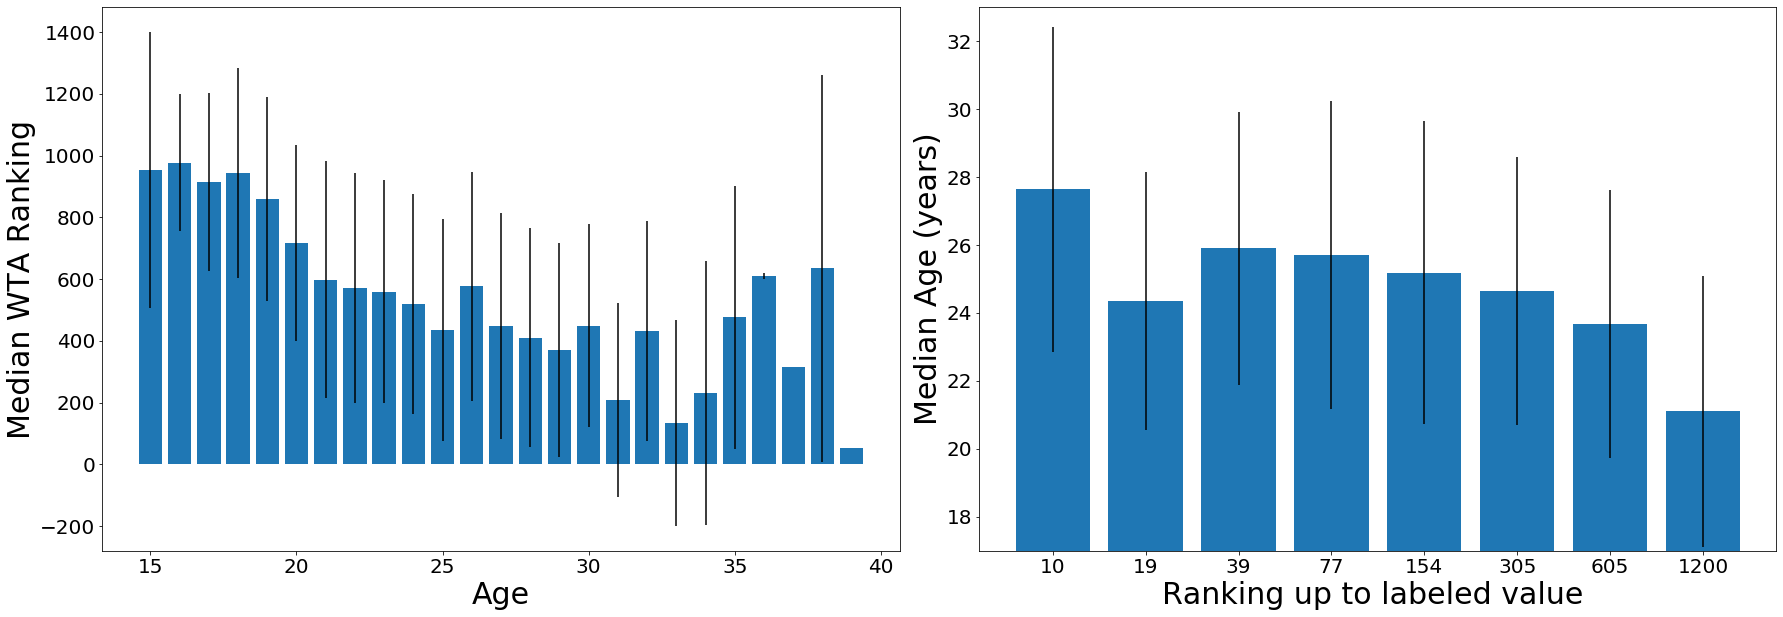

In [367]:
years = range(1980, 2005)
ranks_in_year = dict()
mean = np.zeros(len(years))
median = np.zeros(len(years))
stdev = np.zeros(len(years))
for i, year in enumerate(years): 
    a = playerDF['dob'] >= datetime.datetime(year, 1, 1)
    b = playerDF['dob'] < datetime.datetime(year+1, 1, 1)
    ranks_in_year[year] = playerDF[a&b].index
    mean[i] = np.mean(ranks_in_year[year])
    median[i] = np.median(ranks_in_year[year])
    if len(ranks_in_year[year]) > 1: 
        stdev[i] = np.std(ranks_in_year[year])
        
num_buckets = 8
rankbuckets = list(map(int, np.logspace(np.log(10)/np.log(2), np.log(1200)/np.log(2), num = num_buckets, base = 2)))
rankbuckets.insert(0,0)
agebuckets = dict()
bucketlabel = [None]*num_buckets
median_age = [None]*num_buckets
stdev_age = [None]*num_buckets
for i in range(num_buckets): 
    bucketlabel[i] = (rankbuckets[i] + rankbuckets[i+1])/2
    ages = playerDF.loc[rankbuckets[i]: rankbuckets[i+1], 'dob'].dropna().values
    agebuckets[i] = [(datetime.datetime.today() - age).days/365 for age in ages]
    median_age[i] = np.median(agebuckets[i])
    stdev_age[i] = np.std(agebuckets[i])
    
fig, axes = plt.subplots(1, 2, figsize = (30, 10))
axes[0].bar([2019-year for year in years], median, yerr = stdev)
axes[0].set_xlabel('Age', fontsize = 30)
axes[0].set_ylabel('Median WTA Ranking', fontsize = 30)
axes[0].tick_params(axis = 'both', which = 'major', labelsize = 20)

axes[1].bar(range(num_buckets), median_age, yerr = stdev_age, tick_label = rankbuckets[1:])
plt.xlabel('Ranking up to labeled value ', fontsize = 30)
plt.ylabel('Median Age (years)', fontsize = 30)
axes[1].set_ylim(17, 33)
axes[1].tick_params(axis = 'both', which = 'major', labelsize = 20)

fig.subplots_adjust(wspace = 0.1)


In [399]:
X

array([[ 0.68934367, -0.35103098,  0.17445568, ...,  0.07728729,
        -1.03673318,  1.91120244],
       [-0.29545881, -0.35103098,  0.17445568, ...,  0.09636759,
        -1.09088406,  3.25029138],
       [ 1.04505828, -0.35103098,  0.17445568, ...,  0.1726888 ,
        -1.11409158,  3.83840477],
       ...,
       [ 0.34680368, -0.35103098,  0.17445568, ...,  0.3444115 ,
         1.67081097, -0.700021  ],
       [-1.20648345,  2.84875141,  0.17445568, ..., -0.36155962,
        -0.71182788,  0.08986052],
       [ 1.09248689, -0.35103098,  0.17445568, ..., -0.18983692,
         1.82552778, -0.70997369]])